# Crowded Fields

In [1]:
# Import Packages and setup
import logging
import os

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
idx = 5
datapath = "/Users/fmoolekamp/data/testdata_deblender/sim_data/unmatched_sim"
#datapath = "/Users/fmoolekamp/data/testdata_deblender/sim_data/psf_matched_sim"
psfs = np.load(os.path.join(datapath, "psfs.npz"))["psfs"]
data = np.load(os.path.join(datapath, "images_{0}.npz".format(idx)))
images = data["images"]
filters = data["filters"]

from astropy.table import Table as ApTable
catalog = ApTable.read(os.path.join(datapath, "true_catalog_{0}.fits".format(idx)))
# Only use a single component for each source
catalog = catalog[catalog["component"]!="disk"]
bg_rms = np.array([35]*len(images))

# display psfs
plt.imshow(psfs[0])
plt.show()

# Use Asinh scaling for the images
norm = scarlet.display.Asinh(img=images, Q=20)
# Map i,r,g -> RGB
filter_indices = [3,2,1]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(n), color="b")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/real_data/hsc_cosmos/true_catalog_0.fits'

In [3]:
%%time
# Fit the psfs
target_psf = scarlet.psf_match.fit_target_psf(psfs, scarlet.psf_match.moffat)
#plt.imshow(target_psf,norm=scarlet.display.Asinh(img=target_psf))
#plt.show()
diff_kernels, psf_blend = scarlet.psf_match.build_diff_kernels(psfs, target_psf)

CPU times: user 3.66 s, sys: 26 ms, total: 3.69 s
Wall time: 1.18 s


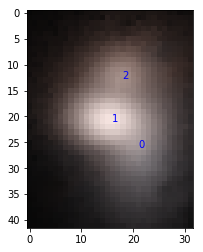

Iterations: 126
54595.15678644909


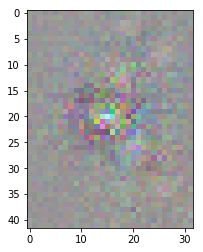

In [10]:
from scarlet.config import Normalization
config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=2, normalization=Normalization.S,
                               update_model=True)
sources = [
    scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, config=config)
    #scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(200, e_rel=1e-3)

model = blend.get_model()
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(n), color="b")
plt.show()
print("Iterations:", blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

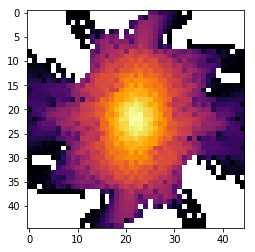

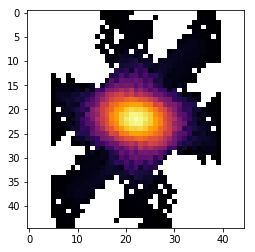

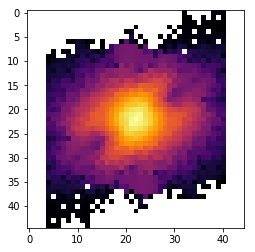

In [7]:
for src in blend.sources:
    morph = src.components[0].morph
    morph = np.ma.array(morph, mask=morph==0)
    norm = scarlet.display.Asinh(img=morph, Q=20)
    plt.imshow(morph, norm=norm)
    plt.show()

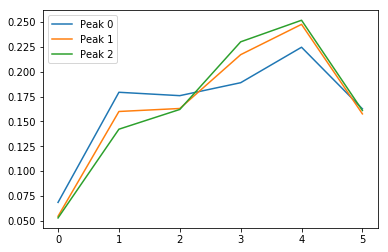

In [87]:
colors = np.array([src.components[0].sed for src in blend.sources])
cnorm = np.sum(colors, axis=1)
seds = colors/cnorm[:, None]
for n,sed in enumerate(seds):
    plt.plot(sed, label="Peak {0}".format(n))
    plt.legend()
    plt.plot()

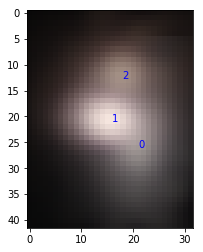

Iterations: 194


In [12]:
from scarlet.config import Normalization
config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=2, normalization=Normalization.S,
                               update_model=True)
sources = [
    scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(200, e_rel=1e-3)

model = blend.get_model()
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(n), color="b")
plt.show()
print("Iterations:", blend.it)
residual = images-model

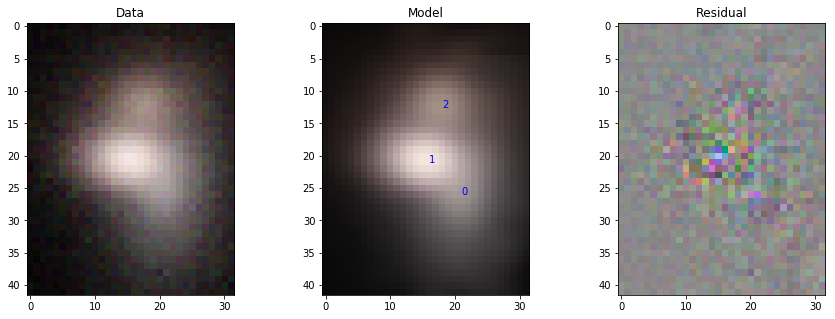

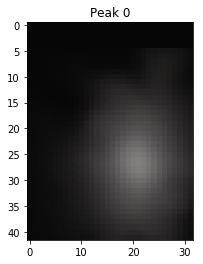

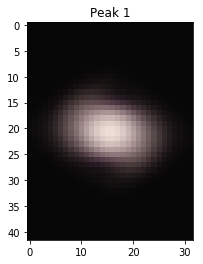

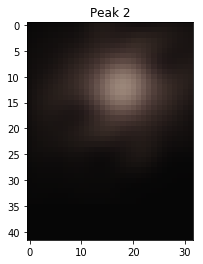

In [22]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
ax[1].imshow(img_rgb)
ax[1].set_title("Model")
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
for n, src in enumerate(catalog):
    ax[1].text(src["x"], src["y"], str(n), color="b")
ax[2].imshow(img_rgb)
ax[2].set_title("Residual")
plt.show()

for n,src in enumerate(blend.sources):
    smodel = blend.get_model(k=n)
    img_rgb = scarlet.display.img_to_rgb(smodel, filter_indices=filter_indices, norm=norm)
    plt.imshow(img_rgb)
    plt.title("Peak {0}".format(n))
    plt.show()